# Install

In [1]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 13.0 MB/s eta 0:00:00


In [2]:
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
!pip install einops
!python -c "import monai" || pip install 'monai[all]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.3 MB/s eta 0:00:00
2023-04-12 02:21:04.156293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 02:21:06.315577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import libraries

In [3]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
# monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import first, set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage, 
    LoadImageD, 
    EnsureChannelFirstD, 
    AddChannelD, 
    ScaleIntensityD, 
    ToTensorD, 
    Compose, 
    AsDiscreteD, 
    SpacingD, 
    OrientationD, 
    ResizeD, 
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    RandDeformD,
    ToTensorD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [4]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0

print('You are using gpu if true, cpu if false:', cuda)

You are using gpu if true, cpu if false: True


# Load data

## Test data

In [5]:
# Dowload data, src: http://medicaldecathlon.com/
dataset = DecathlonDataset(root_dir = "./", 
                           task = "Task06_Lung", section = "training", 
                           transform = None, download = True)
print(f"\nnumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Task06_Lung.tar: 8.53GB [08:38, 17.7MB/s]                            


2023-04-12 02:29:58,249 - INFO - Downloaded: Task06_Lung.tar
2023-04-12 02:30:35,520 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2023-04-12 02:30:35,527 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 272149.50it/s]


number of subjects: 51.
The first element in the dataset is {'image': 'Task06_Lung/imagesTr/lung_014.nii.gz', 'label': 'Task06_Lung/labelsTr/lung_014.nii.gz'}.


In [6]:
# Load random to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": "Task06_Lung/imagesTr/lung_014.nii.gz", 
                     "label": "Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"image shape: {data_check['image'].shape} \nlabel shape: {data_check['label'].shape}")

image shape: torch.Size([512, 512, 589]) 
label shape: torch.Size([512, 512, 589])


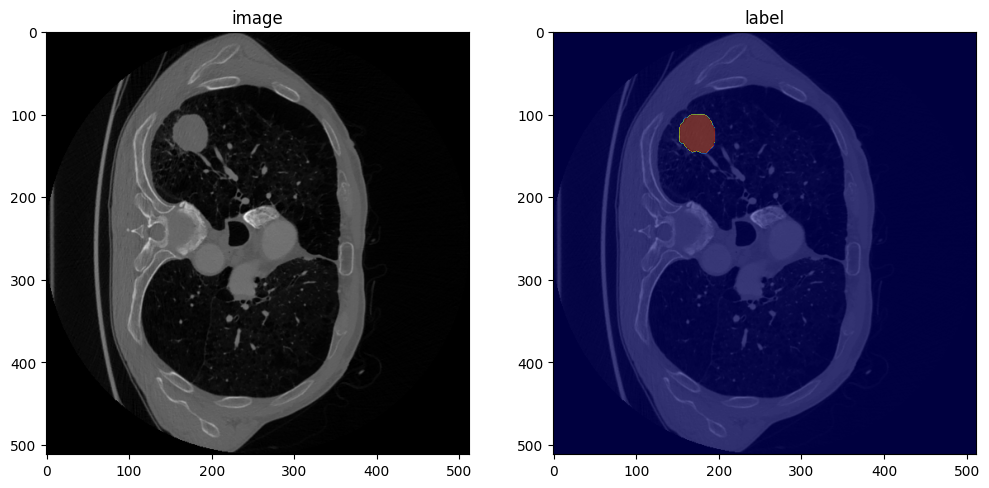

In [7]:
# Visualize check image and label
slide = 379
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")
plt.imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

## Load training set

In [8]:
# Set up transform
KEYS = ["image", "label"]
transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, 
             pixdim = (1., 1., 1.), 
             mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, 
            (128, 128, 64), 
            mode=('trilinear', 'nearest')),
    RandAffineD(keys = KEYS, 
                spatial_size = (128, 128, 64),
                rotate_range = (0, 0, np.pi/12),
                scale_range = (0.1, 0.1, 0.1),
                mode = ('bilinear', 'nearest'),
                prob = 1.0),
    ToTensorD(KEYS),
])

In [ ]:
#edit transforms here
KEYS = ["image", "label"]

train_transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    ScaleIntensityD(keys="image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    RandAffineD(
        keys=KEYS,
        spatial_size=(128, 128, 64),
        rotate_range=(0, 0, np.pi/12),
        scale_range=(0.1, 0.1, 0.1),
        mode=('bilinear', 'nearest'),
        prob=0.5
    ),
    RandFlipD(keys=KEYS, spatial_axis=0, prob=0.5),
    RandRotateD(keys=KEYS, range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.5),
    RandZoomD(keys=KEYS, min_zoom=0.9, max_zoom=1.1, prob=0.5),
    RandDeformD(
        keys=KEYS,
        num_control_points=5,
        image_interpolation='bspline',
        deformation_strength=1.0,
        prob=0.5
    ),
    ToTensorD(keys=KEYS),
])

In [9]:
# Load data
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = transform, download = True)

train_loader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 4)

2023-04-12 02:32:10,726 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2023-04-12 02:32:10,727 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2023-04-12 02:32:10,731 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 51/51 [12:29<00:00, 14.70s/it]


In [10]:
# Check transformed data
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

# Trying to understand what the dimension 2 of the data is
print(training_image[0, :, 0, 0, 39])

Length of training set: 51
check data training image shape: torch.Size([1, 1, 128, 128, 64]) 
check data training label shape: torch.Size([1, 1, 128, 128, 64])
metatensor([0.])


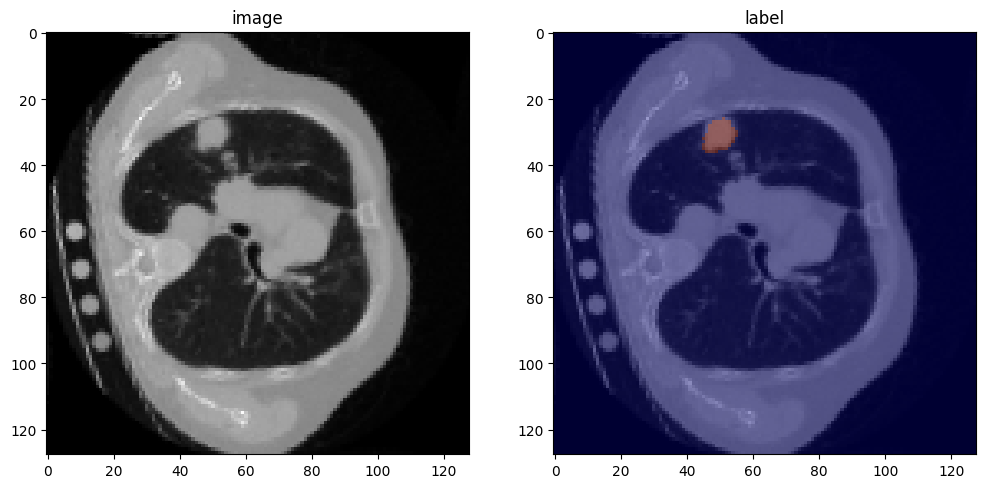

In [51]:
slide = 40
plt.figure("Training Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(training_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.4)

plt.show()

## Load validation set

In [12]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

# Load data
val_dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = True)

val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)

2023-04-12 02:45:20,589 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2023-04-12 02:45:20,591 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2023-04-12 02:45:20,593 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 12/12 [02:58<00:00, 14.85s/it]


In [13]:
# Check transformed data
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

Length of validation set: 12
check data image shape: torch.Size([1, 1, 128, 128, 64]) 
check data label shape: torch.Size([1, 1, 128, 128, 64])


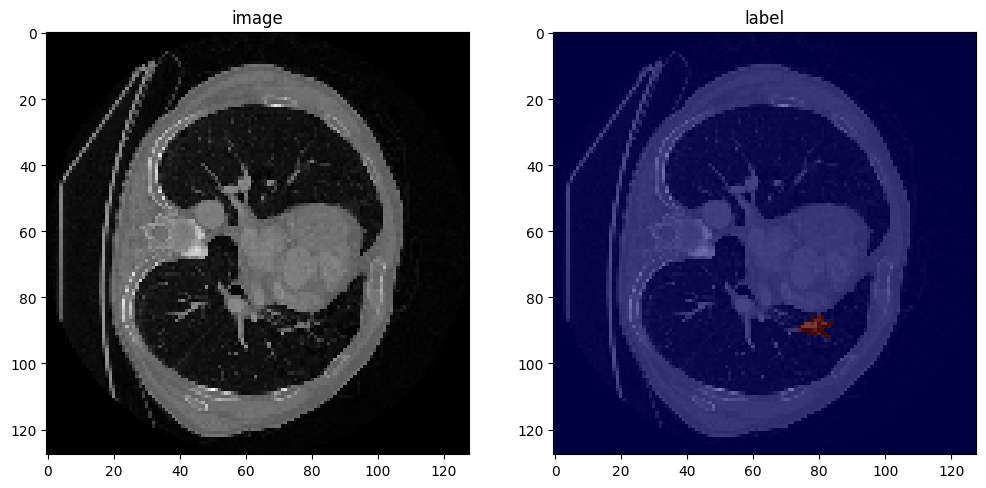

In [14]:
slide = 30
plt.figure("Validation Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(val_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

# Model, Loss, Optimizer

In [26]:
device = torch.device("cuda:0")

UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (64, 128, 256, 512),
    strides = (2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
)

model = UNet(**UNet_metadata).to(device) # using UNet model

loss_function = DiceLoss(to_onehot_y = True, softmax = True) # using Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # using Adam optimizer
dice_metric = DiceMetric(include_background = False, reduction = "mean")

# Start training

In [27]:
max_epochs = 300
val_interval = 1
best_metric = -1
best_metric_epoch = -1
metric_values = []
epoch_loss_values =[]
post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

for epoch in range(max_epochs):
  print("-" * 12)
  print(f"Epoch {epoch + 1}/{max_epochs}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    # A common pytorch Deep Learning format to train model
    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():.4f}")
    
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)

  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
    # Turn model to "eval" mode
    model.eval() 

    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True
    with torch.no_grad():
      for val_data in val_loader:
        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (128, 128, 96)
        sw_batch_size = 1

        # Set AMP for MONAI validation
        val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
        val_output = [post_pred(i) for i in decollate_batch(val_output)]
        val_label = [post_label(i) for i in decollate_batch(val_label)]

        # Compute metric for current iteration
        dice_metric(y_pred = val_output, y = val_label)

      # Aggregate the final mean dice result
      metric = dice_metric.aggregate().item()

      # Reset the status for the next epoch
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        print("saved new best metric model!!!")
        torch.save(model.state_dict(), "best_metric_model.pth")
      
      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {metric:.4f},"
          f" best mean dice: {best_metric:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

print(
    f"train completed, best metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)

Streaming output truncated to the last 5000 lines.
5/51, train_loss: 0.1398
6/51, train_loss: 0.1123
7/51, train_loss: 0.1465
8/51, train_loss: 0.0480
9/51, train_loss: 0.1054
10/51, train_loss: 0.0778
11/51, train_loss: 0.0888
12/51, train_loss: 0.1188
13/51, train_loss: 0.0896
14/51, train_loss: 0.1042
15/51, train_loss: 0.5001
16/51, train_loss: 0.0595
17/51, train_loss: 0.1391
18/51, train_loss: 0.0726
19/51, train_loss: 0.1147
20/51, train_loss: 0.0788
21/51, train_loss: 0.5004
22/51, train_loss: 0.0784
23/51, train_loss: 0.1471
24/51, train_loss: 0.1024
25/51, train_loss: 0.1205
26/51, train_loss: 0.0881
27/51, train_loss: 0.1414
28/51, train_loss: 0.1335
29/51, train_loss: 0.1040
30/51, train_loss: 0.1292
31/51, train_loss: 0.1294
32/51, train_loss: 0.0525
33/51, train_loss: 0.5000
34/51, train_loss: 0.0679
35/51, train_loss: 0.0475
36/51, train_loss: 0.0759
37/51, train_loss: 0.0571
38/51, train_loss: 0.0890
39/51, train_loss: 0.0451
40/51, train_loss: 0.1092
41/51, train_loss:

# Check model and Visualize

In [28]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5027 at epoch: 95


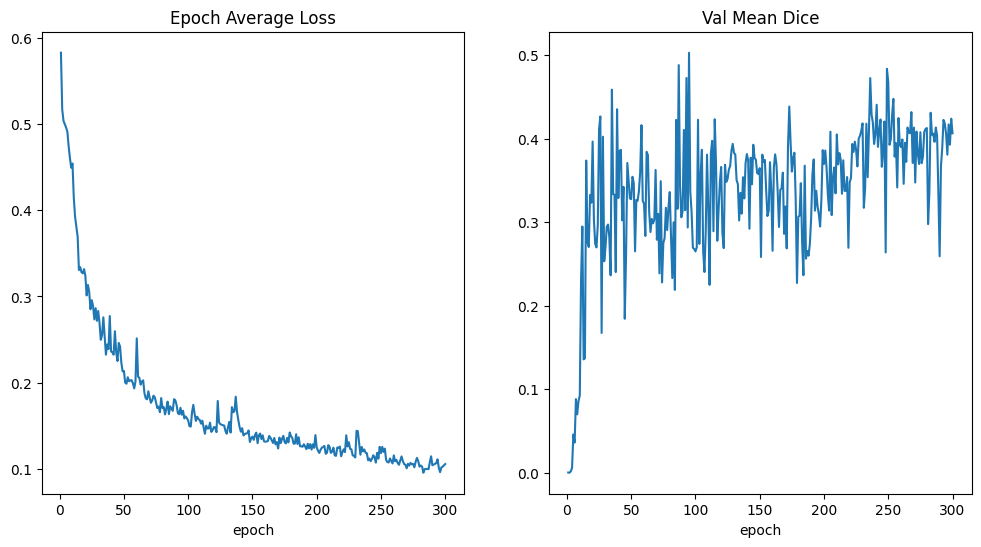

In [29]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig('model_03_graph.png')
plt.show()
# plt.savefig(PATH_NAME+'model.png')

In [30]:
checker = first(val_loader)
image, label = checker['image'], checker['label']

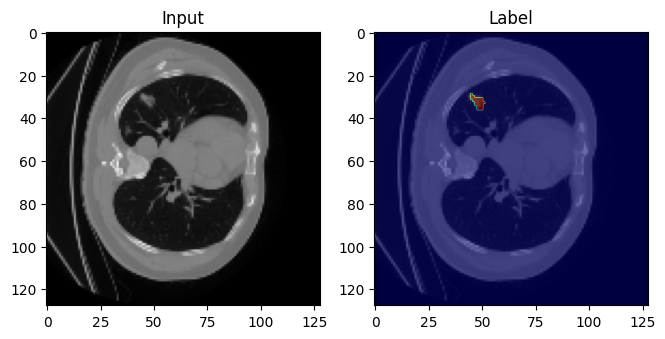

In [41]:
slide = 28
plt.figure("Test Model", (12, 12))

plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

Output shape: torch.Size([1, 2, 128, 128, 64])


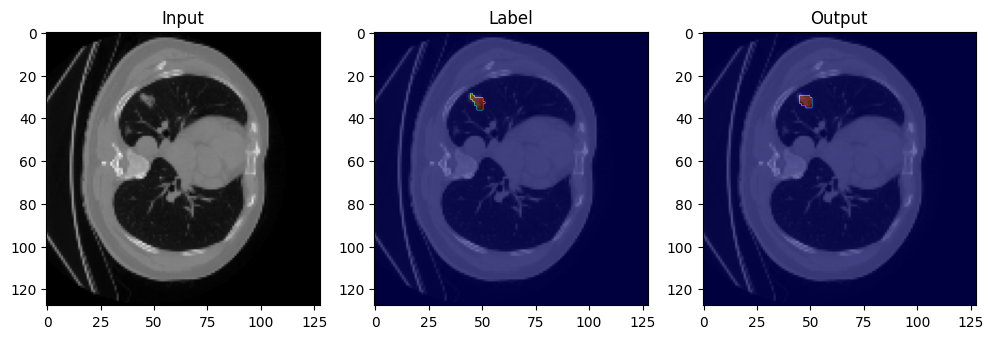

In [42]:
model.cpu()
model.load_state_dict(torch.load("best_metric_model.pth"))

with torch.no_grad():
  output = model(image)
  output = torch.nn.Softmax()(output)
  output = torch.round(output)

  print(f"Output shape: {output.shape}")

  slide = 28
  plt.figure("Test Model", (12, 12))

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

  plt.subplot(1, 3, 2)
  plt.title("Label")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.subplot(1, 3, 3)
  plt.title("Output")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.show()